In [ ]:

import numpy as np
import pandas as pd
import torch
import math as m
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(100, 30),
      torch.nn.ReLU(),
      torch.nn.Linear(30, 7),
      torch.nn.ReLU(),
      torch.nn.Linear(7, 2),
      torch.nn.ReLU()
    )
    self.decoder = torch.nn.Sequential( 
      torch.nn.ReLU(),
      torch.nn.Linear(2, 7),
      torch.nn.ReLU(),
      torch.nn.Linear(7, 30),
      torch.nn.ReLU(),
      torch.nn.Linear(30, 100),
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    return latent_space, self.decoder(latent_space)

In [ ]:
class Branch1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.branch1 = torch.nn.Sequential(
      torch.nn.ReLU(),
      torch.nn.Linear(2, 5),
      torch.nn.ReLU(),
      torch.nn.Linear(5, 12),
      torch.nn.ReLU(),
      torch.nn.Linear(12, 5),
      torch.nn.ReLU(),
      torch.nn.Linear(5, 1)
    )
  
  def forward(self, latent_space):
    return self.branch1(latent_space)

In [ ]:
class Koala:
  def __init__(self, epochs, batch_size, learning_rate=0.001):
    self.autoencoder = AutoEncoder()
    self.branch1 = Branch1()
    self.loss_func = torch.nn.MSELoss()
    self.learning_rate = learning_rate
    self.ae_optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr=learning_rate)
    self.branch1_optimizer = torch.optim.Adam(self.branch1.parameters(), lr=learning_rate)
    self.epochs = epochs
    self.losses = []
    self.batch_size = batch_size

  def train(self, data): #get train and use one dataloader
    dataloader = DataLoader(data, batch_size=self.batch_size) #divide data into batches
    for epoch in range(self.epochs):
      for idx, batch in enumerate(dataloader):
        torch.autograd.set_detect_anomaly(True)
        x = batch[:, :100]
        y = batch[:, 100:].mul(0.001)
        self.ae_optimizer.zero_grad()
        self.branch1_optimizer.zero_grad()
        latent_space, reconstructed = self.autoencoder(x)
        preds = self.branch1(latent_space)
        ae_loss = self.loss_func(reconstructed, x)
        ae_loss.backward(retain_graph=True)
        self.ae_optimizer.step()
        branch1_loss = self.loss_func(preds, y)
        branch1_loss.backward(retain_graph=True)
        self.branch1_optimizer.step()
        self.losses.append((ae_loss.detach().numpy(), branch1_loss.detach().numpy()))
        

  def save(self):
    torch.save(self.autoencoder.state_dict(), '/content/drive/MyDrive/Project_MTL/models/autoencoder.zip')
    torch.save(self.branch1.state_dict(), '/content/drive/MyDrive/Project_MTL/models/branch1.zip')

  def graph_loss(self):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Iterations')
    x = np.arange(0, 400) #this is dying it needs a better second value formula
    y1 = [i[0] for i in self.losses] 
    y2 = [i[1] for i in self.losses]
    plt.plot(x, y1, color='blue')
    plt.plot(x, y2, color='red')
    plt.xlim(0)
    plt.ylim(0)

  def test(self, x_test, y_test):
    ae_weights = torch.load('/content/drive/MyDrive/Project_MTL/models/autoencoder.zip')
    weights1 = torch.load('/content/drive/MyDrive/Project_MTL/models/branch1.zip')
    self.autoencoder.load_state_dict(ae_weights)
    self.branch1.load_state_dict(weights1)
    self.autoencoder.eval()
    self.branch1.eval()
    latent_space, reconstructed = self.autoencoder(x_test)
    preds = self.branch1(latent_space)
    ae_loss = self.loss_func(reconstructed, x_test)
    branch1_loss = self.loss_func(preds, y_test)
    return latent_space, reconstructed, preds, (ae_loss, branch1_loss)

In [ ]:
train_data = torch.tensor(pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/train.csv').drop(columns='Unnamed: 0').values, requires_grad=True, dtype=torch.float32)
train = pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/train.csv').drop(columns='Unnamed: 0')

X = train_data[:, :100]
Y = train_data[:, 100:].mul(0.001)

test = pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/test.csv').drop(columns='Unnamed: 0')
X_test = torch.tensor(test.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32).to(torch.float32)
Y_test = torch.tensor(test['half_life'].to_numpy(), requires_grad=True, dtype=torch.float32).unsqueeze(dim=1).mul(0.001)

In [ ]:
handler = Koala(5, 100)
handler.train(train_data)
handler.graph_loss()
handler.save()

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:156: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib/python3.7/asyncio/base_events.py", li

RuntimeError: ignored

[[0.4191658]
 [0.4191658]
 [0.4191658]
 ...
 [0.4191658]
 [0.4191658]
 [0.4191658]]


(0.0, 1.0496193523336843)

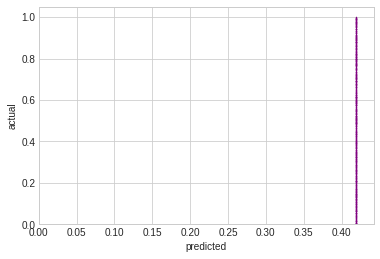

In [ ]:
handler = Koala(100, 100)
results = handler.test(X_test, Y_test)
plt.style.use('seaborn-whitegrid')
#plt.plot(Y_test.detach().numpy(), Y_test.detach().numpy(), color='green', linewidth=0.5)
plt.scatter(results[2].detach().numpy(), Y_test.detach().numpy(), color='purple', s=0.05)
print(results[2].detach().numpy())
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xlim(0)
plt.ylim(0)

In [ ]:
print(results[1])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], grad_fn=<SigmoidBackward0>)


Text(0.5, 1.0, 'half-lives')

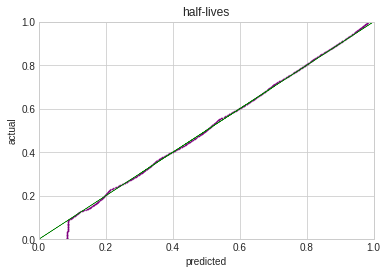

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.plot(Y_test.detach().numpy(), Y_test.detach().numpy(), color='green', linewidth=0.5)
plt.scatter(results[2].detach().numpy(), Y_test.detach().numpy(), color='purple', s=0.05)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('half-lives')

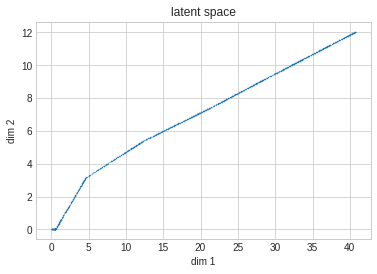

In [ ]:
dim1 = [i[0] for i in results[0].detach().numpy().tolist()]
dim2 = [i[1] for i in results[0].detach().numpy().tolist()]
plt.scatter(dim1, dim2, s=0.03)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title('latent space')
plt.style.use('seaborn-whitegrid')

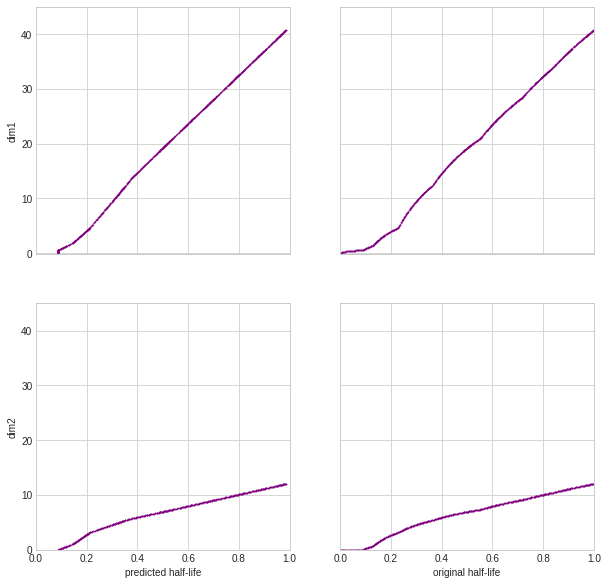

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(results[2].detach().numpy().tolist(), dim1, s=0.1, color='purple')
axs[0, 0].set(xlabel='predicted half-life', ylabel='dim1', xlim=(0, 1), ylim=(-0.1, 45))

axs[0, 1].scatter(Y_test.detach().numpy().tolist(), dim1, s=0.1, color='purple')
axs[0, 1].set(xlabel='original half-life', ylabel='dim1', xlim=(0, 1), ylim=(-0.1, 45))

axs[1, 0].scatter(results[2].detach().numpy().tolist(), dim2, s=0.1, color='purple')
axs[1, 0].set(xlabel='predicted half-life', ylabel='dim2', xlim=(0, 1), ylim=(-0.1, 45))

axs[1, 1].scatter(Y_test.detach().numpy().tolist(), dim2, s=0.1, color='purple')
axs[1, 1].set(xlabel='original half-life', ylabel='dim2', xlim=(0, 1), ylim=(-0.1, 45))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.set_size_inches(10, 10)
plt.style.use('seaborn-whitegrid')

In [ ]:
color = []
for i in range(2000):
    color.append('#%06X' % np.random.randint(0, 0xFFFFFF))

Text(0.5, 1.0, 'Reconstructed')

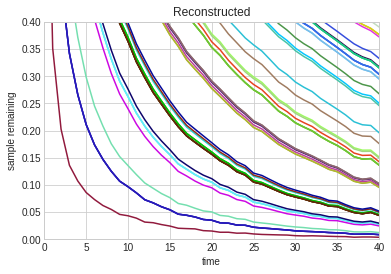

In [ ]:
results = handler.test(X_test, Y_test)
recon = results[1].detach().numpy().tolist()
plt.style.use('seaborn-whitegrid')
x = np.linspace(0, 100, 100, endpoint=False)
for i in np.random.randint(0, high=1899, size=1900):
  plt.plot(x, recon[i], color =color[i])
plt.xlim(0, 40)
plt.ylim(0, 0.4)
plt.xlabel('time')
plt.ylabel('sample remaining')
plt.title('Reconstructed')

Text(0.5, 1.0, 'Original')

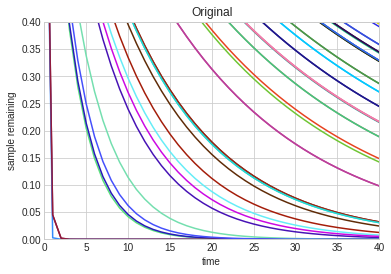

In [ ]:
plt.style.use('seaborn-whitegrid')
x = np.linspace(0, 100, 100, endpoint=False)
for i in np.random.randint(0, high=1899, size=1900):
  plt.plot(x, X_test.detach().numpy().tolist()[i], color=color[i])
plt.xlim(0, 40)
plt.ylim(0, 0.4)
plt.xlabel('time')
plt.ylabel('sample remaining')
plt.title('Original')

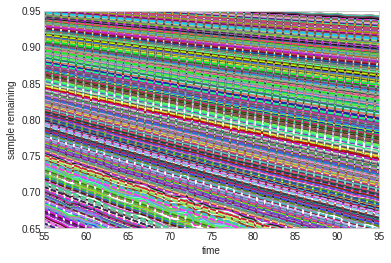

In [ ]:
results = handler.test(X_test, Y_test)
recon = results[1].detach().numpy().tolist()
plt.style.use('seaborn-whitegrid')
x = np.linspace(0, 100, 100, endpoint=False)
for i in np.random.randint(0, high=1899, size=1900):
  plt.plot(x, recon[i], color=color[i])
plt.xlim(55, 95)
plt.ylim(0.65, 0.95)
plt.xlabel('time')
plt.ylabel('sample remaining')
for i in np.random.randint(0, high=1899, size=1900):
  plt.plot(x, X_test.detach().numpy().tolist()[i], '--', color=color[i])
plt.show()